In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model

from sklearn import metrics
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import os
import requests

In [4]:
!unzip "skin-disease.zip" -d /content

Archive:  skin-disease.zip
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0024707.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0024763.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0024771.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0024800.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0024913.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0024948.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0025780.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0025953.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0025957.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC_0025992.jpg  
  inflating: /content/Split_smol/train/Actinic keratosis/ISIC

In [5]:
img_size = (450, 450)

In [6]:
def data_preprocessing(path):
	datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,
	                                                          zoom_range=0.2,
																														horizontal_flip=True,
																														vertical_flip=True,
																														)

	generator = datagen.flow_from_directory(
		path,
		batch_size=25,
 		class_mode='categorical',
		target_size=img_size,
		color_mode="rgb"
    )

	return generator

In [8]:
train_generator = data_preprocessing("/content/Split_smol/train")
validation_generator = data_preprocessing("/content/Split_smol/val")

Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.



Dimensione dell'immagine: (450, 450, 3)



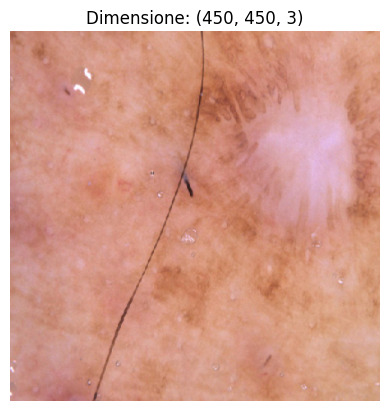

In [10]:
# Ambil satu batch gambar dari train_generator
sample_image, _ = train_generator[0]  # Mengambil batch pertama
image_shape = sample_image.shape[1:]
num_channels = image_shape[-1]

print("\nDimensione dell'immagine:", image_shape)
print()
plt.imshow(sample_image[0])
plt.title(f"Dimensione: {image_shape}")
plt.axis('off')
plt.show()

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', input_shape=(img_size[0], img_size[1], 3), kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis = -1),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis = -1),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(9, activation='softmax')

])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 450, 450, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 450, 450, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 450, 450, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 225, 225, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 225, 225, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 225, 225, 128)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 225, 225, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 225, 225, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,856,649 (106.26 MB)

 Trainable params: 27,853,449 (106.25 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
history_model = model.fit(train_generator, epochs = 30, validation_data = validation_generator)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.2778 - loss: 2.5803 - precision: 0.3026 - recall: 0.1713 - val_accuracy: 0.1215 - val_loss: 12.7443 - val_precision: 0.1167 - val_recall: 0.1160
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3896 - loss: 1.7766 - precision: 0.4756 - recall: 0.2987 - val_accuracy: 0.1160 - val_loss: 11.4306 - val_precision: 0.1173 - val_recall: 0.1160
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4726 - loss: 1.5005 - precision: 0.5720 - recall: 0.3599 - val_accuracy: 0.1823 - val_loss: 3.8517 - val_precision: 0.1854 - val_recall: 0.1547
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5213 - loss: 1.3679 - precision: 0.5819 - recall: 0.4055 - val_accuracy: 0.1602 - val_loss: 2.8626 - val_precision: 0.2048 - val_recall: 0.0939
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4888 - loss: 1.3862 - precision: 0.5670 - recall: 0.3947 - val_accuracy: 0.2210 - val_loss: 2.3298 - val_precisi

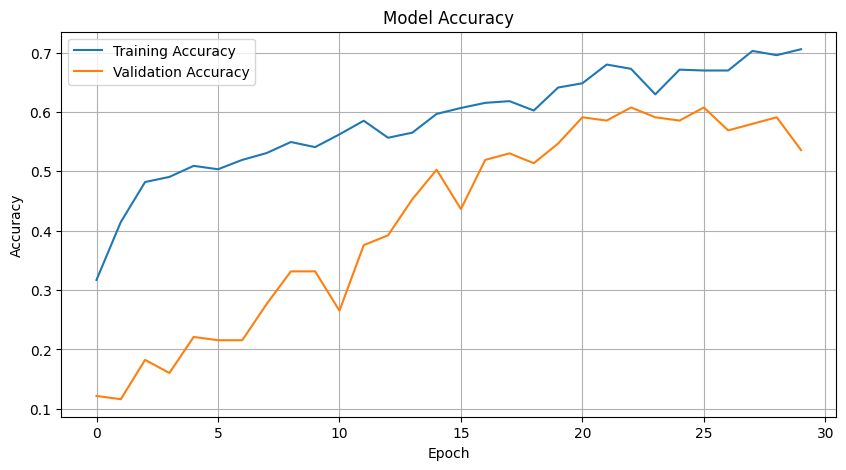

In [23]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))  # Mengatur ukuran figure
plt.plot(history_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()  # Menambahkan grid untuk kemudahan visualisasi
plt.show()

In [34]:
class_names = list(train_generator.class_indices.keys())

def predict_disease(model, img_path):
  img = tf.keras.utils.load_img(img_path, target_size=(img_size[0], img_size[1], 3), color_mode = 'rgb')
  array = tf.keras.utils.img_to_array(img)
  array = array / 255.0

  img_array = np.expand_dims(array, axis=0)
  preds = model.predict(img_array)

  #formatted_predictions = []
  for prediction in preds:
      formatted_predictions = [f'{value:.2f}' for value in prediction]

  top_prob_index = np.argmax(formatted_predictions)
  top_prob = round(float(formatted_predictions[top_prob_index].replace(",", "."))*100, 2)

  print("Probability for each class:", sorted(zip(class_names, formatted_predictions), key=lambda x: x[1], reverse=True))

  plt.imshow(tf.keras.utils.load_img(img_path, target_size=(img_size[0], img_size[1],3), color_mode = 'rgb'))
  plt.axis('off')
  plt.title(f"Class: {list(class_names)[top_prob_index]}; Prob: {top_prob}%")
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
Probability for each class: [('Atopic Dermatitis', '0.84'), ('Tinea Ringworm Candidiasis', '0.12'), ('Melanoma', '0.04'), ('Actinic keratosis', '0.00'), ('Benign keratosis', '0.00'), ('Dermatofibroma', '0.00'), ('Melanocytic nevus', '0.00'), ('Squamous cell carcinoma', '0.00'), ('Vascular lesion', '0.00')]


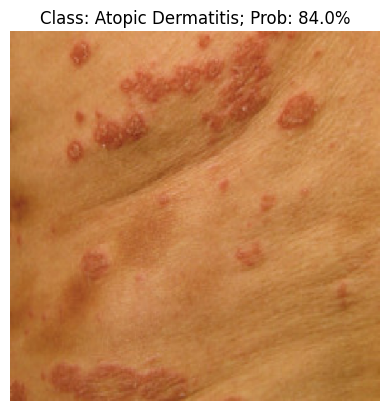

In [40]:
predict_disease(model, "/content/Split_smol/val/Atopic Dermatitis/1_42.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Probability for each class: [('Benign keratosis', '0.90'), ('Melanoma', '0.07'), ('Melanocytic nevus', '0.03'), ('Actinic keratosis', '0.00'), ('Atopic Dermatitis', '0.00'), ('Dermatofibroma', '0.00'), ('Squamous cell carcinoma', '0.00'), ('Tinea Ringworm Candidiasis', '0.00'), ('Vascular lesion', '0.00')]


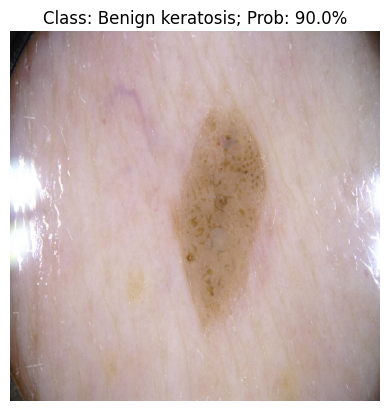

In [41]:
predict_disease(model, "/content/Split_smol/val/Benign keratosis/ISIC_0014649_downsampled.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Probability for each class: [('Dermatofibroma', '0.70'), ('Melanocytic nevus', '0.09'), ('Vascular lesion', '0.09'), ('Squamous cell carcinoma', '0.07'), ('Actinic keratosis', '0.02'), ('Melanoma', '0.02'), ('Atopic Dermatitis', '0.01'), ('Benign keratosis', '0.00'), ('Tinea Ringworm Candidiasis', '0.00')]


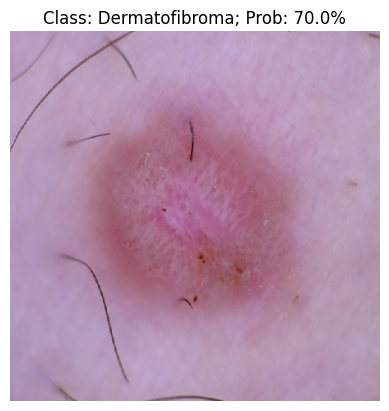

In [19]:
predict_disease(model, "/content/Split_smol/val/Dermatofibroma/ISIC_0024330.jpg")

In [31]:
# Save the trained model as model.h5
model.save('model.h5')

In [22]:
# Mengambil class indices dari generator
class_indices = train_generator.class_indices

# Mengurutkan label berdasarkan indeks
sorted_labels = sorted(class_indices.keys(), key=lambda x: class_indices[x])

# Menyimpan label ke dalam file
with open('label.txt', 'w') as f:
    for label in sorted_labels:
        f.write(f"{label}\n")